In [1]:
import os
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image, ImageChops, ImageEnhance
import cv2

In [2]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

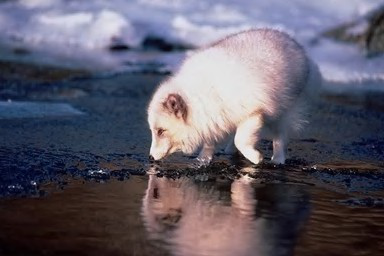

In [3]:
real_image_path = 'C:/Users/Najmi/Downloads/Datasets/CASIA2/Au/Au_ani_00041.jpg'
Image.open(real_image_path)

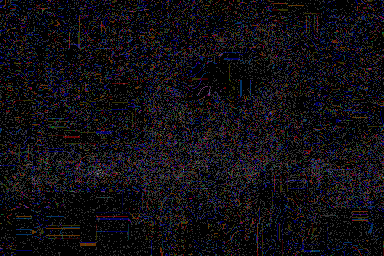

In [4]:
convert_to_ela_image(real_image_path, 95)

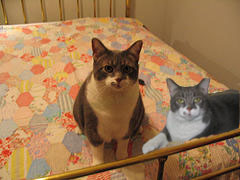

In [6]:
fake_image_path = 'C:/Users/Najmi/Downloads/Datasets/CASIA2/Tp/Tp_D_CRD_S_O_ani10103_ani10111_10637.jpg'
Image.open(fake_image_path)

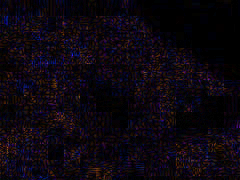

In [8]:
convert_to_ela_image(fake_image_path, 90)

In [9]:
image_size = (224, 224)

In [10]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [11]:
X = []
y = []

In [16]:
import random

path = 'C:/Users/Najmi/Downloads/Datasets/CASIA2/Au'
print(os.walk(path))
for root, dirs, files in os.walk(path):
  for filename in files:
    file_path = os.path.join(root, filename)
    if filename.lower().endswith(('jpg', 'png')):
      X.append(prepare_image(file_path))
      y.append(1)
    if len(X)==3000:
        break

random.shuffle(X)

print(len(X), len(y))

<generator object _walk at 0x0000021BA8354600>
3000 3000


In [17]:
import random
#count = 0
path = 'C:/Users/Najmi/Downloads/Datasets/CASIA2/Tp'
for root, dirs, files in os.walk(path):
    for filename in files:
        file_path = os.path.join(root, filename)
        if filename.lower().endswith(('jpg', 'png', 'tif', 'tiff')):
            X.append(prepare_image(file_path))
            y.append(0)
        if len(X)==4500:
            break

In [18]:
from keras.utils import to_categorical
X = np.array(X)
y = to_categorical(y, 2)
X = X.reshape(-1, 224, 224, 3)

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=5)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3600 3600
900 900


In [20]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5,mode='max', restore_best_weights=True)

In [21]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from keras.models import Sequential

In [22]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [23]:
from keras.layers import BatchNormalization
model = build_model()

In [24]:
epochs = 10
batch_size = 32
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/10
113/113 [==============================] - 377s 3s/step - loss: 2.7796 - accuracy: 0.8061 - val_loss: 1.0541 - val_accuracy: 0.3411
Epoch 2/10
113/113 [==============================] - 383s 3s/step - loss: 0.6968 - accuracy: 0.8247 - val_loss: 3.3443 - val_accuracy: 0.3411
Epoch 3/10
113/113 [==============================] - 366s 3s/step - loss: 0.4803 - accuracy: 0.8411 - val_loss: 6.1732 - val_accuracy: 0.3411
Epoch 4/10
113/113 [==============================] - 365s 3s/step - loss: 0.3441 - accuracy: 0.8556 - val_loss: 2.6298 - val_accuracy: 0.8422
Epoch 5/10
113/113 [==============================] - 386s 3s/step - loss: 0.2896 - accuracy: 0.8661 - val_loss: 0.3244 - val_accuracy: 0.8889
Epoch 6/10
113/113 [==============================] - 369s 3s/step - loss: 0.2761 - accuracy: 0.8847 - val_loss: 0.4748 - val_accuracy: 0.7533
Epoch 7/10
113/113 [==============================] - 378s 3s/step - loss: 0.2552 - accuracy: 0.8836 - val_loss: 0.2770 - val_accuracy: 0.8944

In [30]:
model.evaluate(X_val,Y_val)

NameError: name 'X_val' is not defined

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 56, 56, 64)        256       
 Normalization)                                                  
                                                        

In [31]:
# make predictions on the validation set
y_pred = model.predict(X_val)
# print the first 10 predictions
print(y_pred[:10])

29/29 [==============================] - 31s 1s/step
[[3.5262172e-18 1.0000000e+00]
 [4.5013599e-37 1.0000000e+00]
 [9.7756666e-01 2.2433387e-02]
 [9.9952257e-01 4.7741566e-04]
 [1.8929868e-17 1.0000000e+00]
 [6.7018593e-24 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [9.8428530e-01 1.5714740e-02]
 [0.0000000e+00 1.0000000e+00]
 [9.9924016e-01 7.5984473e-04]]


In [32]:
# get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)
# print the first 10 labels
print(y_pred_labels[:10])

[1 1 0 0 1 1 1 0 1 0]


In [28]:
# Save model
model.save("image_forgery_detection_model.keras")

In [15]:
from tensorflow import keras
model = keras.models.load_model('saved model/image_forgery_detection_model.keras')

In [33]:
# make predictions on the validation set
y_pred = model.predict(X_val)
# print the first 10 predictions
print(y_pred[:10])

29/29 [==============================] - 31s 1s/step
[[3.5262172e-18 1.0000000e+00]
 [4.5013599e-37 1.0000000e+00]
 [9.7756666e-01 2.2433387e-02]
 [9.9952257e-01 4.7741566e-04]
 [1.8929868e-17 1.0000000e+00]
 [6.7018593e-24 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [9.8428530e-01 1.5714740e-02]
 [0.0000000e+00 1.0000000e+00]
 [9.9924016e-01 7.5984473e-04]]


In [17]:
from PIL import Image
import numpy as np
from keras.models import load_model

# Load the trained model
# model = keras.models.load_model('image_forgery_detection_model.keras')

# Function to preprocess image using ELA
def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)
    
    # Convert the image to ELA format
    ela_image = convert_to_ela_image(image_path, quality=90)
    
    # Resize and normalize the ELA image
    ela_image = ela_image.resize((224, 224))
    ela_array = np.array(ela_image).reshape(-1, 224, 224, 3) / 255.0
    
    return ela_array

# Function to predict if image is tampered or not
def predict_tampered(image_path):
    # Preprocess the input image
    processed_image = preprocess_image(image_path)
    
    # Make prediction using the trained model
    prediction = model.predict(processed_image)
    
    # Extract predicted class (0 for tampered, 1 for authentic)
    predicted_class = np.argmax(prediction)
    
    # Return the prediction result
    if predicted_class == 0:
        return "Tampered"
    else:
        return "Authentic"

In [22]:
input_image_path = "C:/Users/Najmi/Machine Learning FYP/Unseen Dataset/Fk/image6.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)

1/1 [==============================] - 0s 59ms/step
Prediction: Tampered


In [23]:
input_image_path = "C:/Users/Najmi/Machine Learning FYP/Unseen Dataset/Rl/rl1.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)

1/1 [==============================] - 0s 84ms/step
Prediction: Tampered


In [24]:
input_image_path = "C:/Users/Najmi/Machine Learning FYP/Unseen Dataset/Rl/rl2.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)

1/1 [==============================] - 0s 61ms/step
Prediction: Authentic


In [25]:
input_image_path = "C:/Users/Najmi/Machine Learning FYP/Unseen Dataset/Fk/Image5.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)

1/1 [==============================] - 0s 63ms/step
Prediction: Tampered


In [28]:
input_image_path = "C:/Users/Najmi/Machine Learning FYP/Unseen Dataset/Fk/Image2.jpeg"
result = predict_tampered(input_image_path)
print("Prediction:", result)


1/1 [==============================] - 0s 62ms/step
Prediction: Tampered


In [29]:
input_image_path = "D:/Whatsapp Images/IMG-20230808-WA0029.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)

1/1 [==============================] - 0s 57ms/step
Prediction: Tampered


In [33]:
input_image_path = "C:/Users/Najmi/Downloads/Datasets/CASIA2/Tp/Tp_D_CRD_S_O_ani10111_ani10103_10635.jpg"
result = predict_tampered(input_image_path)
print("Prediction:", result)


1/1 [==============================] - 1s 1s/step
Prediction: Tampered


In [13]:
print(X)

[]


In [14]:
print(y)

[]
